In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [1]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
import torch
import torch.nn as nn
from model_evaluation import get_vis_data, compare_sactter_plots
from sklearn.manifold import TSNE
from tqdm import tqdm
import numpy as np
from datapreperation import get_processed_input_examples_full
from peft import (
    get_peft_model,
    LoraConfig,
)
RANK = 2
PEFT_CONFIG = LoraConfig(inference_mode=False, 
              r=RANK, 
              lora_alpha=RANK*2, 
              lora_dropout=0.05,
              # target_modules=["q_lin","k_lin"]
              target_modules=['value','query']
              )


class MLPLayer(nn.Module):
    """
    Head for getting sentence representations over RoBERTa/BERT's CLS representation.
    """
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()
    def forward(self, features, **kwargs):
        x = self.dense(features)
        x = self.activation(x)
        return x
    

class STS_model(nn.Module): 
    def __init__(self, model_path, device='cpu', pef_config=None): 
      super(STS_model, self).__init__() 

      # Load model from HuggingFace Hub
      config = AutoConfig.from_pretrained(model_path, return_dict=True)
      self.device = device
      self.tokenizer = AutoTokenizer.from_pretrained(model_path)
      self.Bert_representations = AutoModel.from_pretrained(model_path)
      if pef_config is not None:
        self.Bert_representations = get_peft_model(self.Bert_representations, pef_config)
      self.Bert_representations.to(device)
      self.Bert_representations.print_trainable_parameters()
      self.MLP_layer = MLPLayer(config)
      self.MLP_layer.to(device)


        
    def forward(self, model_input): 
      # Tokenize sentences if input is a string or a list of strings
        if isinstance(model_input, str) or (isinstance(model_input, list) and isinstance(model_input[0], str)):
            model_input = self.tokenizer(model_input, padding=True, truncation=True, max_length=128, return_tensors="pt")
            model_input = model_input.to(self.device)
            model_output = self.Bert_representations(**model_input)
        else:
            model_output = self.Bert_representations(**model_input)
        
        # Get the representation of [CLS]
        model_output = model_output.last_hidden_state[:, 0, :]
        model_output = self.MLP_layer(model_output)
        return model_output


    

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'sentence-transformers/all-MiniLM-L12-v1'
model = STS_model(model_name, device=device, pef_config=PEFT_CONFIG)
print('Loaded model to device: ', device)


trainable params: 36864 || all params: 33396864 || trainable%: 0.1103816214600269
Loaded model to device:  cuda


In [3]:
data_path = './dataset/data.csv'
data = get_processed_input_examples_full(data_path)
cleaned_data = []
for q in data:
    if all(isinstance(item, str) for item in q.texts):
        cleaned_data.append(q)
data = cleaned_data



data_path = './dataset/data.csv'
questions, ids, node_names = get_vis_data(data_path=data_path)
questions = questions[:256]
ids = ids[:256]
node_names = node_names[:256]

Number of InputExamples: 1112200
Example of InputExample: ['السلام عليكم', 'سلام', 'عندي مشكلة']
Number of InputExamples after removing duplicates: 1055631


In [4]:
bare_model_embeddings = []
for q in tqdm(questions):
    emb = model(q).detach().cpu().numpy()
    bare_model_embeddings.append(emb)
    
bare_model_embeddings = np.array(bare_model_embeddings).squeeze()
bare_model_embeddings_2d = TSNE(n_components=2).fit_transform(bare_model_embeddings)


print('bare model embeddings shape: ', bare_model_embeddings.shape)
print('bare model embeddings 2d shape: ', bare_model_embeddings_2d.shape)

100%|██████████| 256/256 [00:11<00:00, 22.57it/s]


bare model embeddings shape:  (256, 384)
bare model embeddings 2d shape:  (256, 2)


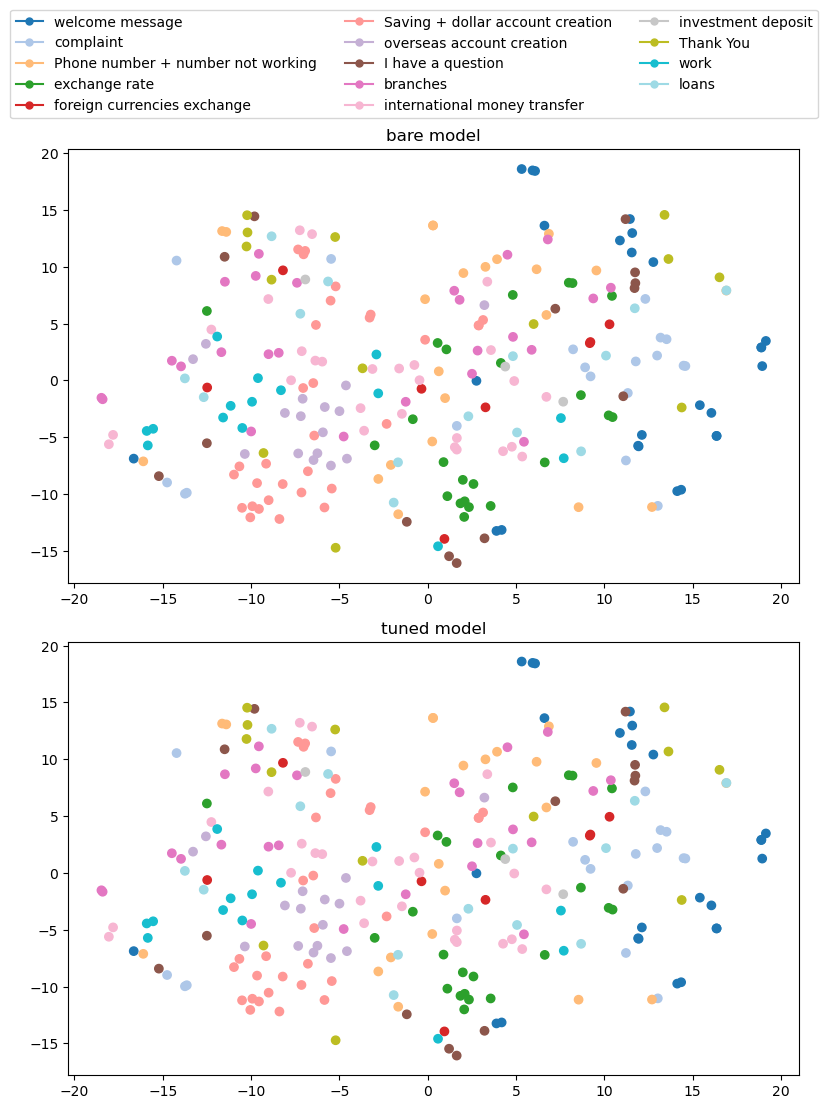

In [5]:
compare_sactter_plots(bare_model_embeddings_2d, bare_model_embeddings_2d, ids)


In [6]:
# create dataloader for triplet texts in bathces

from torch.utils.data import DataLoader
import random

class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, device='cpu', batch_size=None, shuffle=True):
        self.data = data
        if shuffle:
            random.shuffle(self.data)
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = 0
        for item in self.data:
            for text in item.texts:
                self.max_len = max(self.max_len, len(text))
        self.batch_size = batch_size
        self.batched_data = []
        if self.batch_size is not None:
            current_batch = []
            for i, item in enumerate(self.data):
                if i % self.batch_size == 0 and i != 0:
                    self.batched_data.append(current_batch)
                    current_batch = []
                
                current_batch.append(item.texts)
                #TODO: add Last batch with less than batch_size elements
            self.batched_data = np.array(self.batched_data)
            print('Batched data shape: ', self.batched_data.shape)
            
            
        


    def __len__(self):
        if self.batch_size is not None:
            return len(self.batched_data)
        else:
            return len(self.data)
    
    def __getitem__(self, idx):
        if self.batch_size is not None:
            batch = self.batched_data[idx]
            anchors = batch[:, 0].tolist()
            positives = batch[:, 1].tolist()
            negatives = batch[:, 2].tolist()
            encoded_anchors = self.tokenizer(anchors, padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')
            encoded_positives = self.tokenizer(positives, padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')
            encoded_negatives = self.tokenizer(negatives, padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')
            encoded_anchors.to(self.device)
            encoded_positives.to(self.device)
            encoded_negatives.to(self.device)
            return encoded_anchors, encoded_positives, encoded_negatives
        item = self.data[idx]
        texts = item.texts
        encoded_anchor = self.tokenizer(texts[0], padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')
        encoded_positive = self.tokenizer(texts[1], padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')
        encoded_negative = self.tokenizer(texts[2], padding='max_length', max_length=self.max_len, truncation=True, return_tensors='pt')
        encoded_anchor.to(self.device)
        encoded_positive.to(self.device)
        encoded_negative.to(self.device)
        return encoded_anchor, encoded_positive, encoded_negative


        

In [7]:
batch_size = 4
train_dataset = TripletDataset(data, model.tokenizer, device=device, batch_size=batch_size)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
num_epochs = 5
loss = 0
epoch=0
steps = 0
eval_every = 1000
total_loss = 0
save_model_every = 1000

Batched data shape:  (263907, 4, 3)


In [8]:
for epoch in range(num_epochs):
        epoch_loss = 0
        tbar = tqdm(train_dataset, unit='batch', desc=f'Epoch {epoch} current loss: {loss} ')
        for input in tbar:
                anchor = model(input[0])
                positive = model(input[1])
                negative = model(input[2])
                
                loss = triplet_loss(anchor, positive, negative)
                epoch_loss += loss.item()
                total_loss += loss.item()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                tbar.set_description(f'Epoch {epoch} current loss: {loss}')
                if steps+1 % eval_every == 0:
                        print(f'Epoch {epoch} current loss: {loss}')
                        avarage_loss = total_loss / eval_every
                        total_loss = 0
                        print(f'Steps {steps} avarage loss: {avarage_loss}')
                        
                

                        tuned_model_embeddings = []
                        for q in tqdm(questions):
                                emb = model(q).detach().cpu().numpy()
                                tuned_model_embeddings.append(emb)
                                
                        tuned_model_embeddings = np.array(tuned_model_embeddings).squeeze()
                        tuned_model_embeddings_2d = TSNE(n_components=2).fit_transform(tuned_model_embeddings)
                        compare_sactter_plots(bare_model_embeddings_2d, tuned_model_embeddings_2d, ids)

                if steps % save_model_every == 0:
                        mlp_model = model.MLP_layer
                        lora_model = model.Bert_representations

                        
                        
                        torch.save(mlp_model.state_dict(), f'./models/LoRa/mlp_model_{steps}.pth')
                        lora_model.save_pretrained(f'./models/LoRa/lora_model_{steps}')


                steps += 1




                
                
        print(f'Epoch loss: {epoch_loss}')
        


Epoch 0 current loss: 0.7967214584350586:   0%|          | 14/263907 [00:03<18:28:25,  3.97batch/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 │   │   │   │   loss = triplet_loss(anchor, positive, negative)                             │
│   10 │   │   │   │   epoch_loss += loss.item()                                                   │
│   11 │   │   │   │   total_loss += loss.item()                                                   │
│ ❱ 12 │   │   │   │   loss.backward()                                                             │
│   13 │   │   │   │   optimizer.step()                                                            │
│   14 │   │   │   │   optimizer.zero_grad()                                                       │
│   15 │   │   │   │   tbar.set_description(f'Epoch {epoch} current loss: {loss}')                 │
│                                                                                                  │
│ c:\Users\Edin\anaconda3\envs\amazon\lib\site-packages\torch\_tensor.py:487 in backward           │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ c:\Users\Edin\anaconda3\envs\amazon\lib\site-packages\torch\autograd\__init__.py:200 in backward │
│                                                                                                  │
│   197 │   # The reason we repeat same the comment below is that                                  │
│   198 │   # some Python versions print out the first line of a multi-line function               │
│   199 │   # calls in the traceback and some print out the last line                              │
│ ❱ 200 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   201 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   202 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   203                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
lora_model = model.Bert_representations

lora_model.push_to_hub('lora_model', use_auth_token=True)

In [ ]:
############### Fine Tuning Using Adapter Modules #####################
from peft import (
    get_peft_model,
    LoraConfig,
)
RANK = 2
PEFT_CONFIG = LoraConfig(inference_mode=False, 
              r=RANK, 
              lora_alpha=RANK*2, 
              lora_dropout=0.05,
              # target_modules=["q_lin","k_lin"]
              target_modules=['value','query']
              )
base_model = model.Bert_representations
peft_model = get_peft_model(base_model, PEFT_CONFIG)

model.Bert_representations = peft_model

In [ ]:
model.Bert_representations.print_trainable_parameters()

In [ ]:
base_model.add_adapter()